# Imports

In [1]:
!pip install seaborn_qqplot
!pip install pyarrow
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from seaborn_qqplot import pplot
import os
import pandas as pd
sns.set(style='whitegrid', rc = {'figure.figsize':(12,8)})

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


Matplotlib is building the font cache; this may take a moment.


In [2]:
def perform_kstest(real, generated):
    #perform the two-sample ks test
    dstat, pvalue = stats.ks_2samp(real, generated)
    return dstat


def compare_distibutions(ori_data, gmm_data, timegan_data, title='Comparison of the distributions', x='Load (kW)', dvalue='overall'):
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    fig.suptitle(title)
    
    real = ori_data.reshape(-1)
    gmm = gmm_data.reshape(-1)
    timegan = timegan_data.reshape(-1)
    xmin = np.minimum(real.min(), real.min())
    xmax = np.maximum(real.max(), real.max())
    bins = np.linspace(xmin, xmax, 25)
    alpha = 0.5
    
    ax1.hist(real, bins, label='original', alpha=alpha)
    ax1.hist(gmm, bins, label='gmm', alpha=alpha)
    ax1.set_xlabel(x)
    ax1.set_ylabel('Frequency')
    ax1.legend()
    
    # make x range for the timegan histogram
    xmin = np.minimum(real.min(), real.min())
    xmax = np.maximum(real.max(), real.max())
    bins = np.linspace(xmin, xmax, 25)

    ax2.hist(real, bins, label='original', alpha=alpha)
    ax2.hist(timegan, bins, label='timegan', alpha=alpha)
    ax2.set_xlabel(x)
    ax2.set_ylabel('Frequency')
    ax2.legend()

    plt.show()

    
    # cumulitave plot
    s_real = np.sort(real)
    s_gmm = np.sort(gmm)
    s_timegan = np.sort(timegan)
    
    y = np.arange(len(real)) / float(len(real))
    # plotting
    plt.xlabel(x)
    plt.ylabel('cumulative probability')

    plt.title('CDF comparison')

    plt.plot(s_real, y, '--',  label='original')
    plt.plot(s_gmm, y,  label='gmm')
    plt.plot(s_timegan, y,  label='timegan')
    plt.xlim([xmin, xmax])
    plt.legend()
#     plt.xlim([0, 10])
    plt.show()
    gmm_d = perform_kstest(s_real, s_gmm)
    timegan_d = perform_kstest(s_real, s_timegan)
    print(f'gmm d-statistic: {np.round(gmm_d, 3)}')
    print(f'timegan d-statistic: {np.round(timegan_d, 3)}')


# Settings

In [7]:
#msr_options = ["3 011 014", "3 021 415", "3 018 004", "3 007 577", "3 004 052"]
# voor deze twee is de loadflow berekening gedaan
msr_options = ["3 011 014", "3 018 004"]
msr = msr_options[1]
print(f'chosen msr: {msr}')

chosen msr: 3 018 004


In [8]:
def read_loadflow(path):
    results = (pd.read_csv(path)
               .iloc[:,1:]
               .set_index('EAN')
              )
    # df with min_values
    min_cols = results.iloc[:,::2].columns
    df_min = results[min_cols]
    df_min.loc[:,'m'] = df_min.mean(axis=1)
    df_min.loc[:,'med'] = df_min.median(axis=1)
    df_min.loc[:,'sd'] = df_min.std(axis=1)
    df_min.loc[:,'se'] = df_min.sem(axis=1)
    df_min.loc[:,'p05'] = df_min.quantile(.05, axis=1)
    df_min.loc[:,'p95'] = df_min.quantile(.05, axis=1)
    
    # df with max values
    max_cols = results.iloc[:,1::2].columns
    df_max = results[max_cols]
    df_max.loc[:,'m'] = df_max.mean(axis=1)
    df_max.loc[:,'med'] = df_max.median(axis=1)
    df_max.loc[:,'sd'] = df_max.std(axis=1)
    df_max.loc[:,'se'] = df_max.sem(axis=1)
    df_max.loc[:,'p05'] = df_max.quantile(.05, axis=1)
    df_max.loc[:,'p95'] = df_max.quantile(.05, axis=1)
    
    return (df_min, df_max)



## load all the data

In [9]:
loadflow_output_path = '../data/loadflow_output/'

In [10]:
timegan_min, timegan_max = read_loadflow(f'{loadflow_output_path}timegan-{msr}_50_v.csv')
timegan_norm_min, timegan_norm_max = read_loadflow(f'{loadflow_output_path}timegan_kjv-{msr}_50_v.csv')

gmm_min, gmm_max = read_loadflow(f'{loadflow_output_path}gmm-{msr}_50_v.csv')
gmm_norm_min, gmm_norm_max = read_loadflow(f'{loadflow_output_path}gmm_kjv-{msr}_50_v.csv')

loadflow_min, loadflow_max = read_loadflow(f'{loadflow_output_path}loadflow-{msr}_50_v.csv')

#real == geschaalde profielen waarop getraind is. Bij deze resultaten zijn de profielen niet afzonderlijk geschaald per huis in de loadflow berekening
real_min, real_max = read_loadflow(f'{loadflow_output_path}real-{msr}_50_v.csv')

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


# Overview
Hier zijn de d-statistieken van de KS-test (maximale absolute verschil tussen de cumulatieve distributies) van de generatieve modellen vs de echte profielen geplot
## Scaled

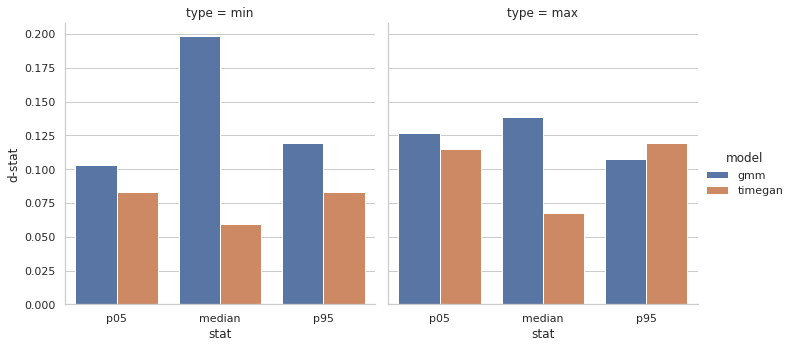

In [11]:
dstats_min_gmm = [perform_kstest(real_min.p05 ,gmm_min.p05), perform_kstest(real_min.med ,gmm_min.med), perform_kstest(real_min.p95 ,gmm_min.p95)]
dstats_min_timegan = [perform_kstest(real_min.p05 ,timegan_min.p05), perform_kstest(real_min.med ,timegan_min.med), perform_kstest(real_min.p95, timegan_min.p95)]

dstats_max_gmm = [perform_kstest(real_max.p05 ,gmm_max.p05), perform_kstest(real_max.med ,gmm_max.med), perform_kstest(real_max.p95 ,gmm_max.p95)]
dstats_max_timegan = [perform_kstest(real_max.p05 ,timegan_max.p05), perform_kstest(real_max.med ,timegan_max.med), perform_kstest(real_max.p95, timegan_max.p95)]


dstat_dict = {'d-stat' : dstats_min_gmm + dstats_min_timegan + dstats_max_gmm + dstats_max_timegan , 'stat': ['p05', 'median', 'p95']*4, 'model': ['gmm']*3 + ['timegan']*3 + ['gmm']*3 + ['timegan']*3, 'type': ['min']*6 + ['max']*6}
dstat_df = pd.DataFrame(dstat_dict)
sns.catplot(data=dstat_df,  y='d-stat', x='stat', hue='model', kind='bar', col='type')

Average ratios: $\frac{generated_v}{real_v}$

In [12]:
print(f'average timegan ratios (min, max): ({round(np.mean(timegan_min.med/real_min.med), 3)}, {round(np.mean(timegan_max.med/real_max.med), 3)})')
print(f'average gmm ratios (min, max): ({round(np.mean(gmm_min.med/real_min.med), 3)}, {round(np.mean(gmm_max.med/real_max.med), 3)})')

average timegan ratios (min, max): (1.012, 1.007)
average gmm ratios (min, max): (0.873, 0.916)


## Normalised

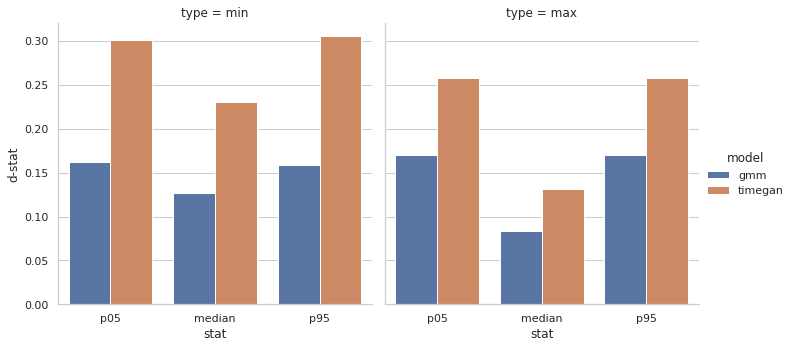

In [13]:
dstats_min_gmm = [perform_kstest(loadflow_min.p05 ,gmm_norm_min.p05), perform_kstest(loadflow_min.med ,gmm_norm_min.med), perform_kstest(loadflow_min.p95 ,gmm_norm_min.p95)]
dstats_min_timegan = [perform_kstest(loadflow_min.p05 ,timegan_norm_min.p05), perform_kstest(loadflow_min.med ,timegan_norm_min.med), perform_kstest(loadflow_min.p95, timegan_norm_min.p95)]

dstats_max_gmm = [perform_kstest(loadflow_max.p05 ,gmm_norm_max.p05), perform_kstest(loadflow_max.med ,gmm_norm_max.med), perform_kstest(loadflow_max.p95 ,gmm_norm_max.p95)]
dstats_max_timegan = [perform_kstest(loadflow_max.p05 ,timegan_norm_max.p05), perform_kstest(loadflow_max.med ,timegan_norm_max.med), perform_kstest(loadflow_max.p95, timegan_norm_max.p95)]


dstat_dict = {'d-stat' : dstats_min_gmm + dstats_min_timegan + dstats_max_gmm + dstats_max_timegan , 'stat': ['p05', 'median', 'p95']*4, 'model': ['gmm']*3 + ['timegan']*3 + ['gmm']*3 + ['timegan']*3, 'type': ['min']*6 + ['max']*6}
dstat_df = pd.DataFrame(dstat_dict)
sns.catplot(data=dstat_df,  y='d-stat', x='stat', hue='model', kind='bar', col='type')


In [34]:
print('--------------------median----------------------------')
print(f'average timegan (median) ratios (min, max): ({round(np.mean(timegan_norm_min.med/loadflow_min.med), 3)}, {round(np.mean(timegan_norm_max.med/loadflow_max.med), 3)})')
print(f'average gmm (median) ratios (min, max): ({round(np.mean(gmm_norm_min.med/loadflow_min.med), 3)}, {round(np.mean(gmm_norm_max.med/loadflow_max.med), 3)})')
print('--------------------5 percentile----------------------------')
print(f'average timegan (5 percentile) ratios (min, max): ({round(np.mean(timegan_norm_min.p05/loadflow_min.p05), 3)}, {round(np.mean(timegan_norm_max.p05/loadflow_max.p05), 3)})')
print(f'average gmm (5 percentile) ratios (min, max): ({round(np.mean(gmm_norm_min.p05/loadflow_min.p05), 3)}, {round(np.mean(gmm_norm_max.p05/loadflow_max.p05), 3)})')
print('--------------------95 percentile----------------------------')
print(f'average timegan (95 percentile) ratios (min, max): ({round(np.mean(timegan_norm_min.p95/loadflow_min.p95), 3)}, {round(np.mean(timegan_norm_max.p95/loadflow_max.p95), 3)})')
print(f'average gmm (95 percentile) ratios (min, max): ({round(np.mean(gmm_norm_min.p95/loadflow_min.p95), 3)}, {round(np.mean(gmm_norm_max.p95/loadflow_max.p95), 3)})')

--------------------median----------------------------
average timegan (median) ratios (min, max): (0.925, 0.964)
average gmm (median) ratios (min, max): (0.979, 1.007)
--------------------5 percentile----------------------------
average timegan (5 percentile) ratios (min, max): (0.865, 0.928)
average gmm (5 percentile) ratios (min, max): (0.99, 0.993)
--------------------95 percentile----------------------------
average timegan (95 percentile) ratios (min, max): (0.864, 0.927)
average gmm (95 percentile) ratios (min, max): (0.994, 0.994)


# Min differences
## Scaled comparison 
### 5 percentile

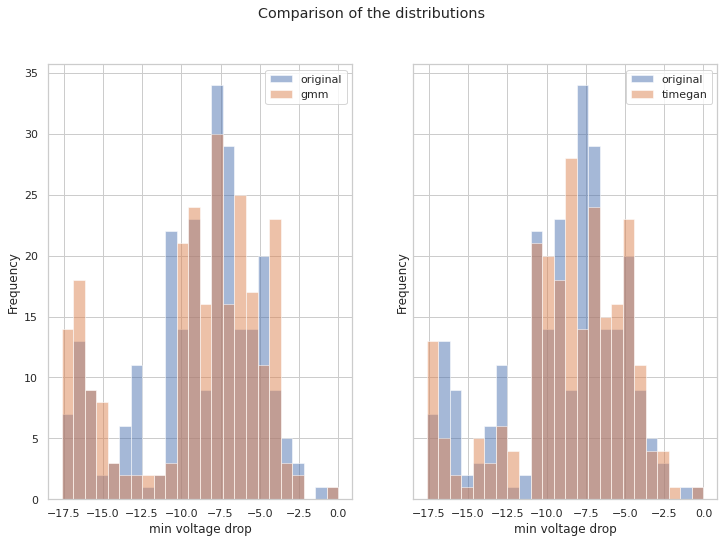

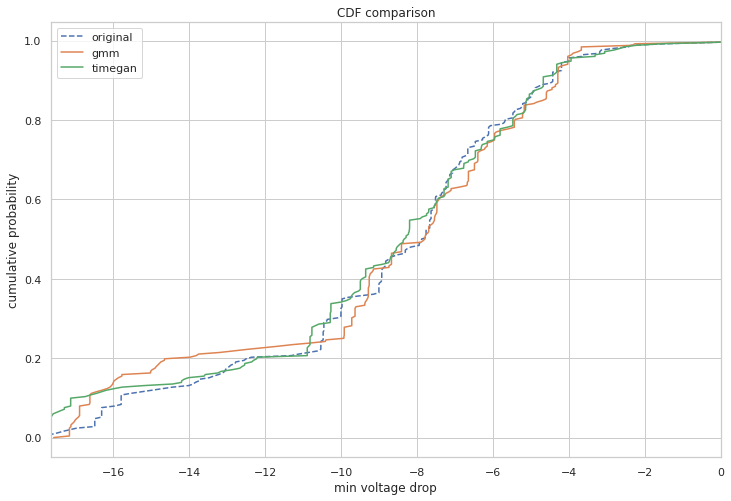

gmm d-statistic: 0.103
timegan d-statistic: 0.083


In [15]:
compare_distibutions(real_min.p05.array, gmm_min.p05.array, timegan_min.p05.array, x='min voltage drop')

### 95 percentile

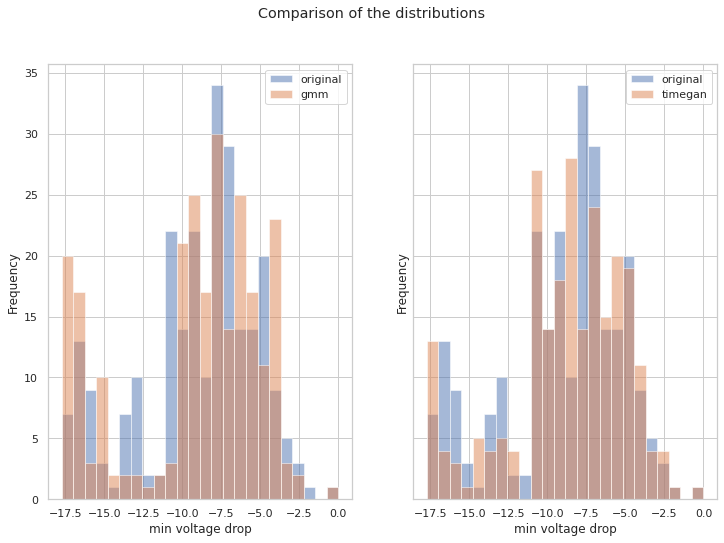

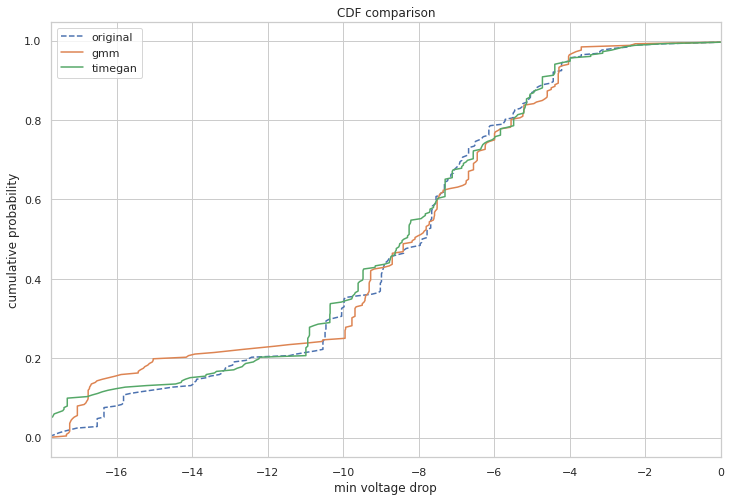

gmm d-statistic: 0.119
timegan d-statistic: 0.083


In [16]:
compare_distibutions(real_min.p95.array, gmm_min.p95.array, timegan_min.p95.array, x='min voltage drop')

### median

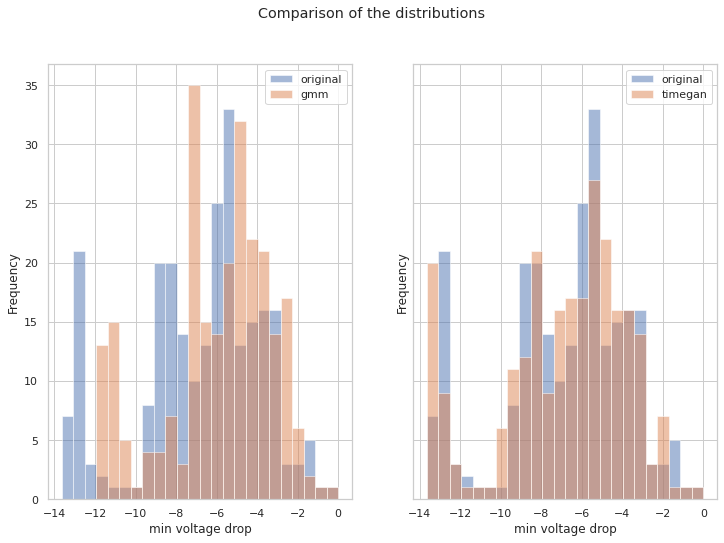

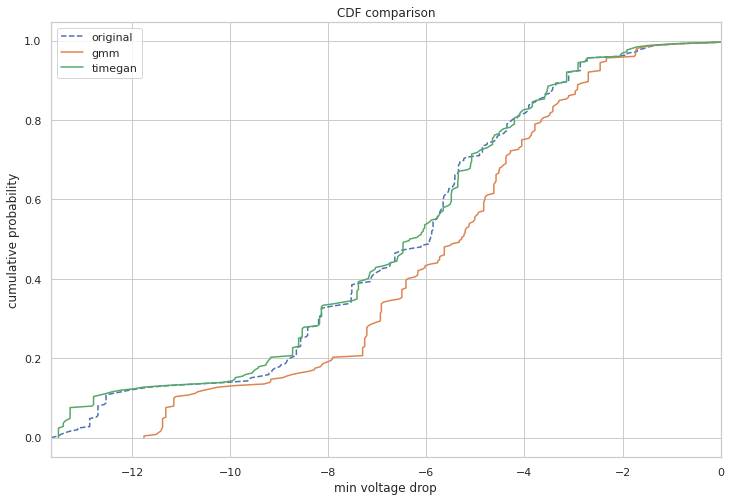

gmm d-statistic: 0.198
timegan d-statistic: 0.06


In [17]:
compare_distibutions(real_min.med.array, gmm_min.med.array, timegan_min.med.array, x='min voltage drop')

## Normalized comparison

### Median

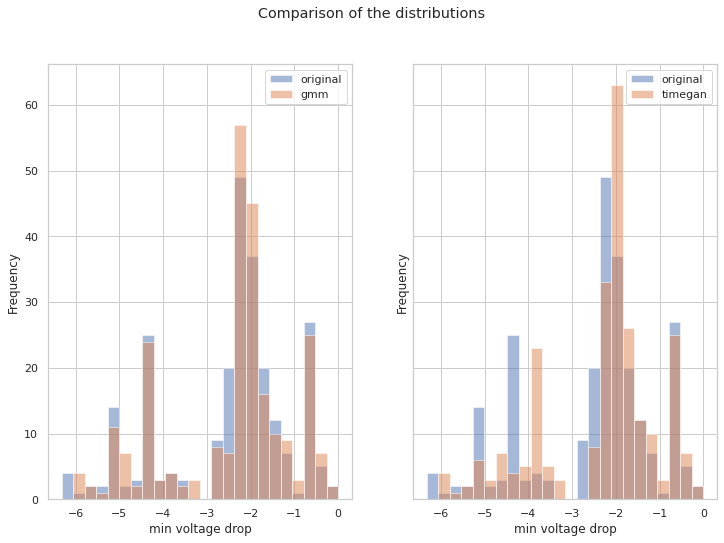

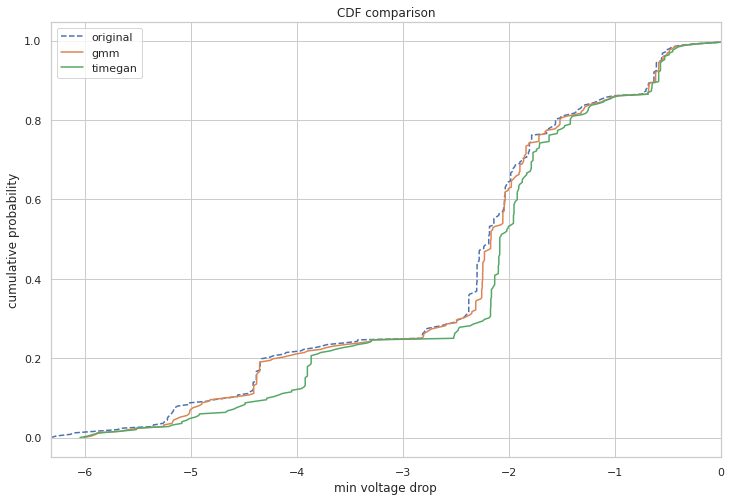

gmm d-statistic: 0.127
timegan d-statistic: 0.23


In [18]:
compare_distibutions(loadflow_min.med.array, gmm_norm_min.med.array, timegan_norm_min.med.array, x='min voltage drop')

# 5 percentile

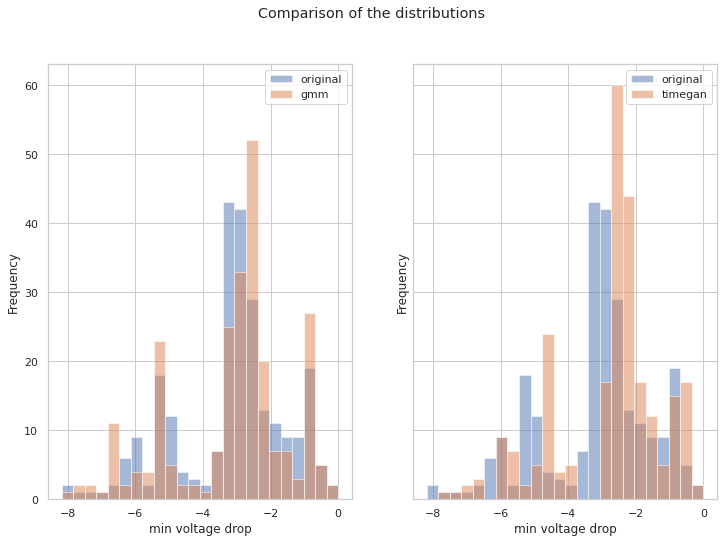

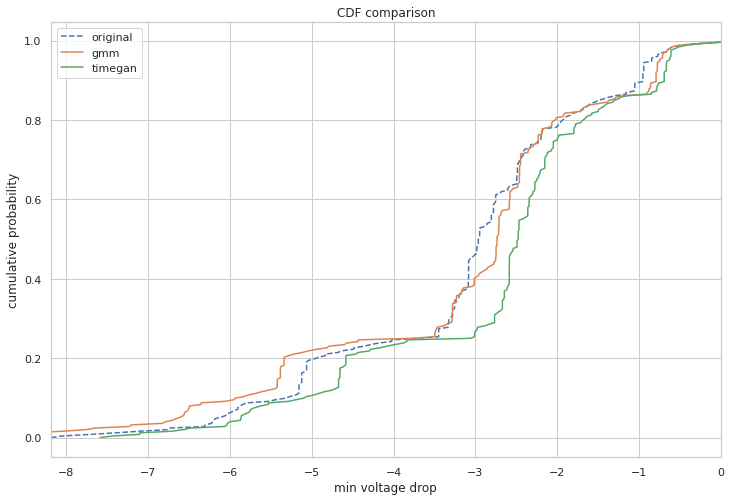

gmm d-statistic: 0.163
timegan d-statistic: 0.302


In [19]:
compare_distibutions(loadflow_min.p05.array, gmm_norm_min.p05.array, timegan_norm_min.p05.array, x='min voltage drop')

# 95 percentile

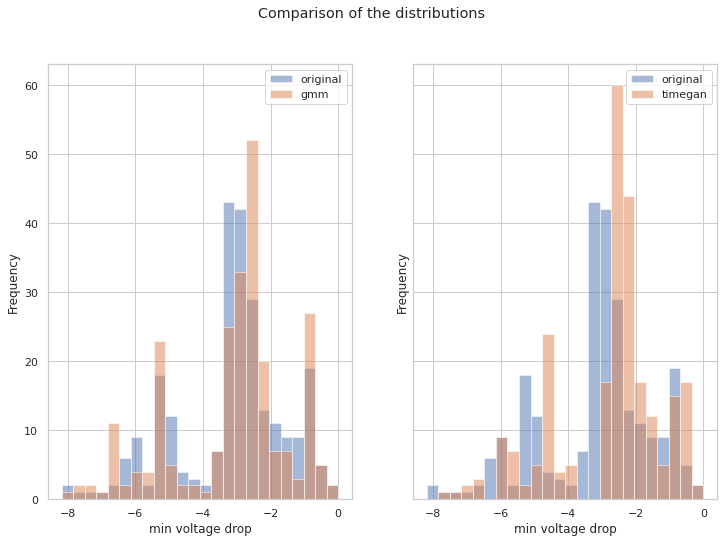

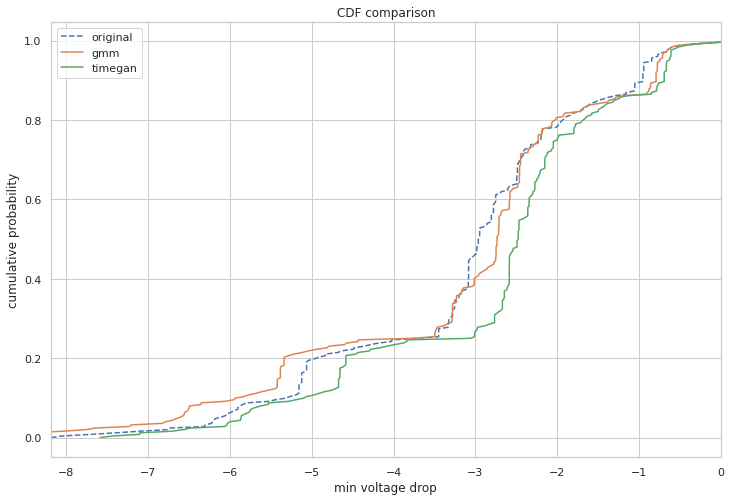

gmm d-statistic: 0.163
timegan d-statistic: 0.302


In [20]:
compare_distibutions(loadflow_min.p05.array, gmm_norm_min.p05.array, timegan_norm_min.p05.array, x='min voltage drop')

In [21]:
print(f'gmm average sd: {gmm_min.sd.mean()}')
print(f'timegan average sd: {timegan_min.sd.mean()}')
print(f'real average sd: {real_min.sd.mean()}')
print(f'loadflow average sd: {loadflow_min.sd.mean()}')

gmm average sd: 1.710186899382212
timegan average sd: 1.230381336865053
real average sd: 1.2755072535682304
loadflow average sd: 0.36038009497663614


# Max differences

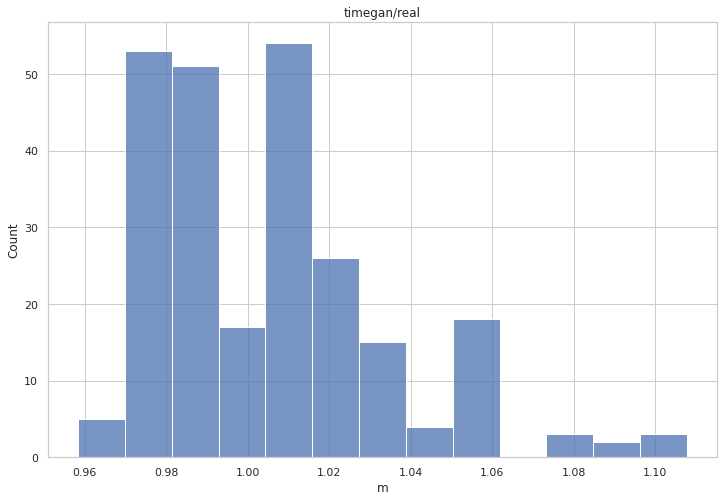

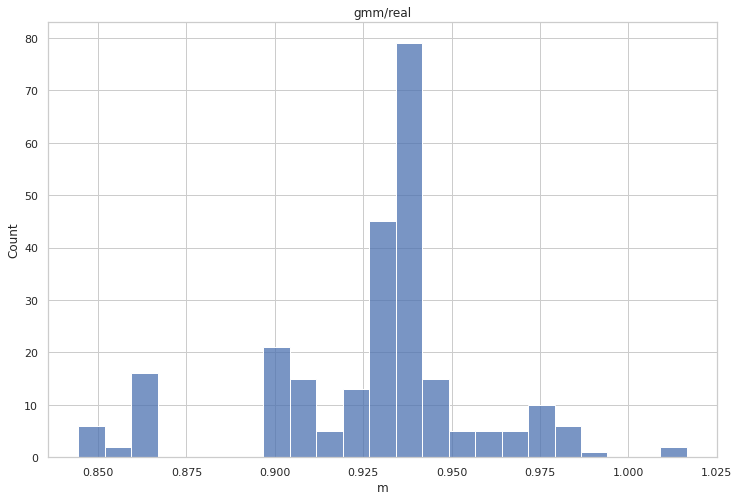

In [22]:
sns.histplot(timegan_max.m / real_max.m)
plt.title('timegan/real')
plt.show()
plt.title('gmm/real')
sns.histplot(gmm_max.m / real_max.m)
plt.show()

## Scaled


## 5 percentile

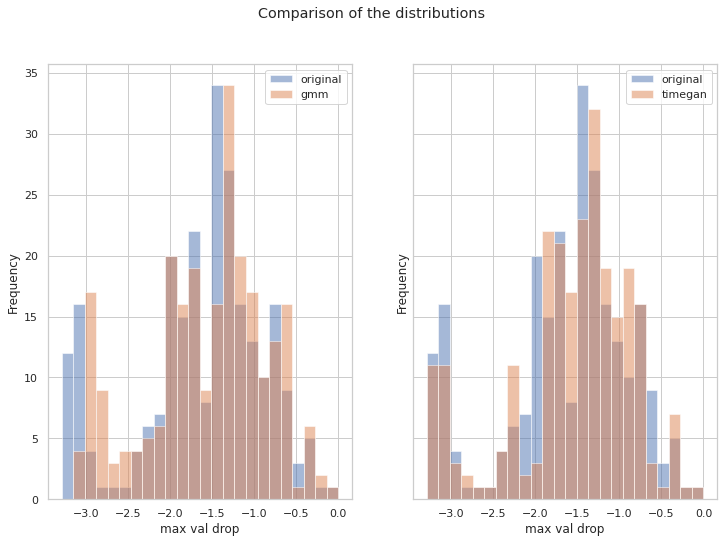

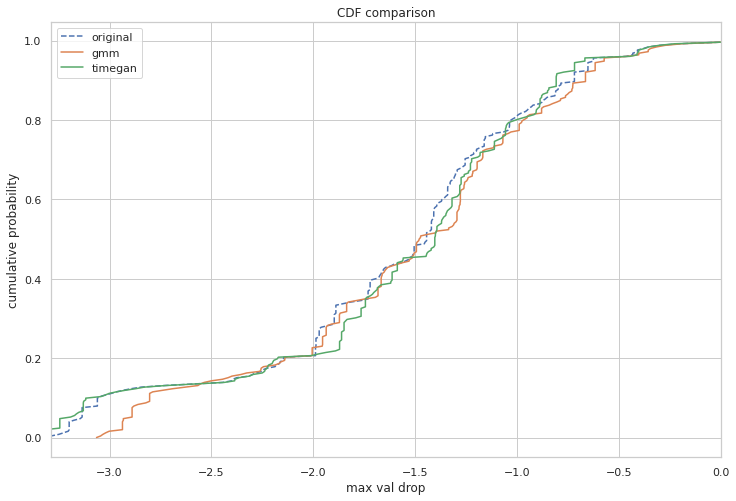

gmm d-statistic: 0.127
timegan d-statistic: 0.115


In [23]:
compare_distibutions(real_max.p05.array, gmm_max.p05.array, timegan_max.p05.array, x='max val drop')

## median

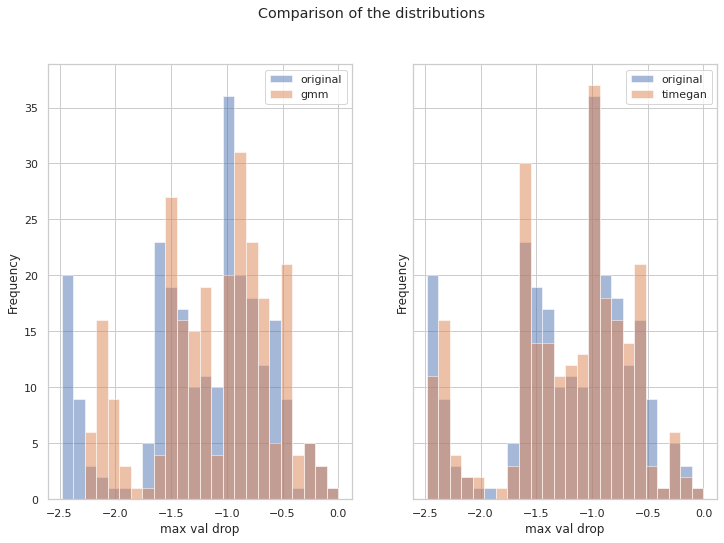

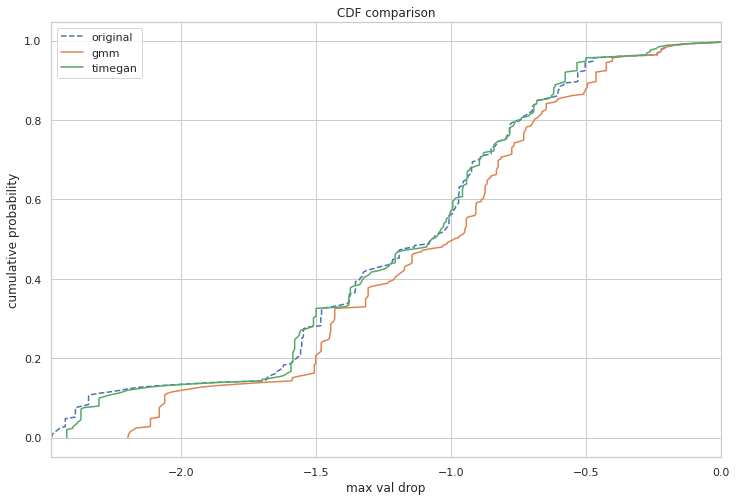

gmm d-statistic: 0.139
timegan d-statistic: 0.067


In [24]:
compare_distibutions(real_max.med.array, gmm_max.med.array, timegan_max.med.array, x='max val drop')

## 95 percentile

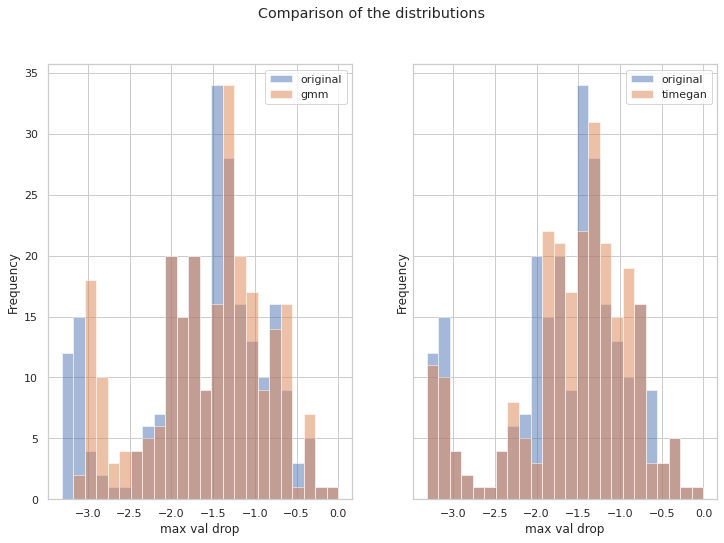

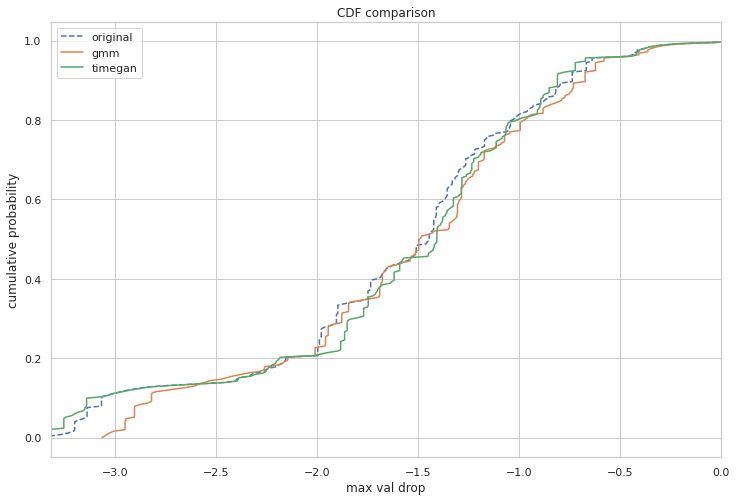

gmm d-statistic: 0.107
timegan d-statistic: 0.119


In [25]:
compare_distibutions(real_max.p95.array, gmm_max.p95.array, timegan_max.p95.array, x='max val drop')

# Normalised

## median

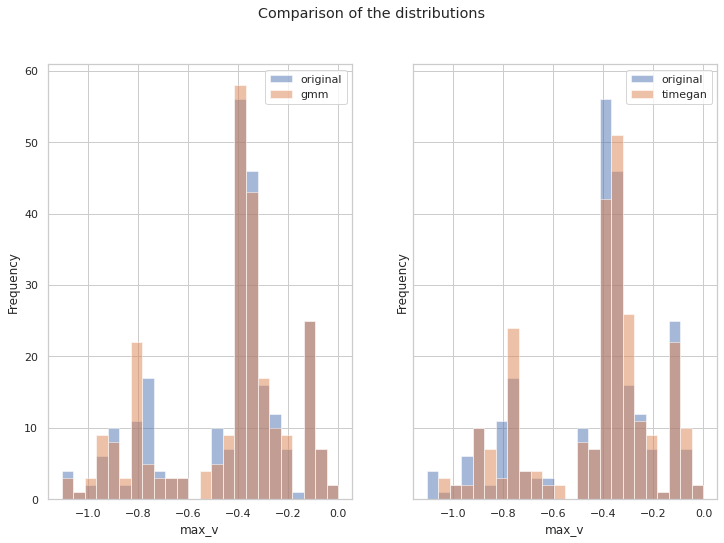

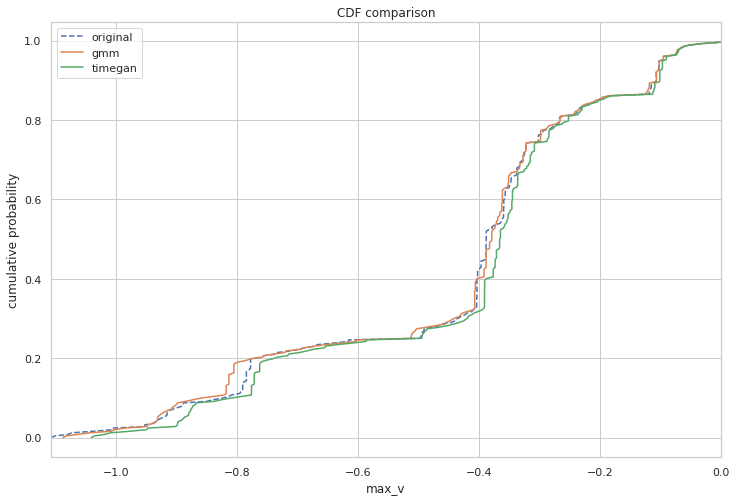

gmm d-statistic: 0.083
timegan d-statistic: 0.131


In [26]:
compare_distibutions(loadflow_max.med.array, gmm_norm_max.med.array, timegan_norm_max.med.array, x='max_v')

## 5 percentile

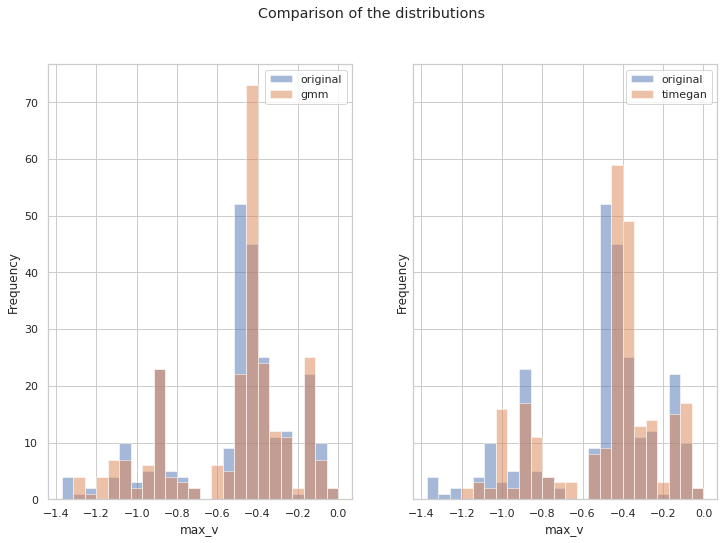

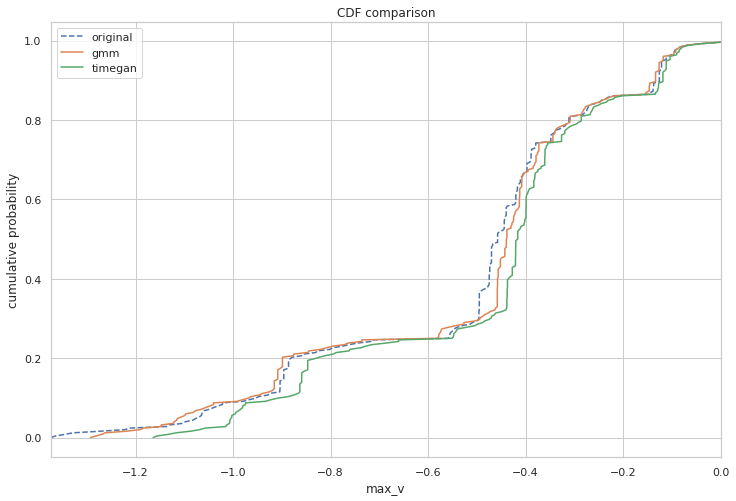

gmm d-statistic: 0.171
timegan d-statistic: 0.258


In [27]:
compare_distibutions(loadflow_max.p05.array, gmm_norm_max.p05.array, timegan_norm_max.p05.array, x='max_v')

## 95 percentile

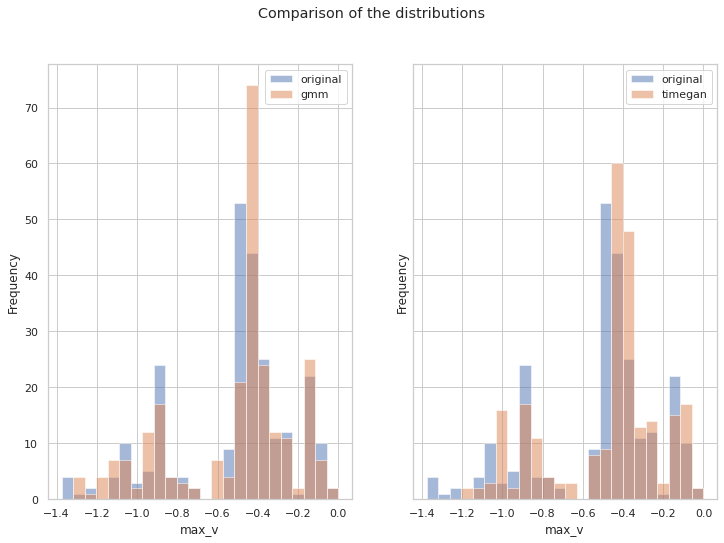

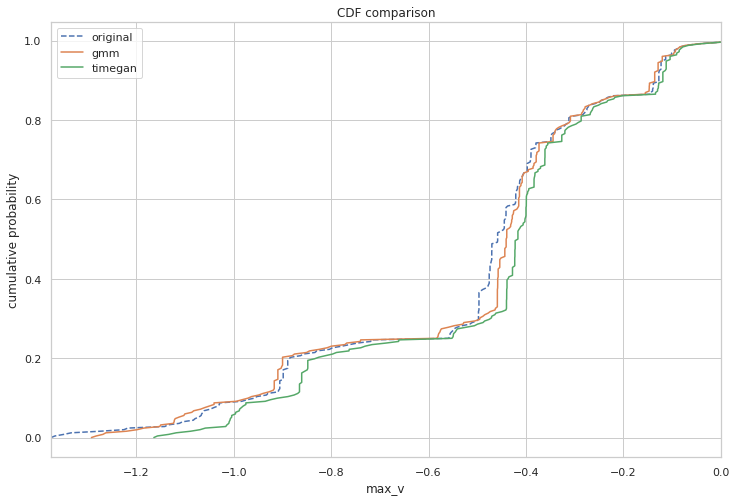

gmm d-statistic: 0.171
timegan d-statistic: 0.258


In [28]:
compare_distibutions(loadflow_max.p95.array, gmm_norm_max.p95.array, timegan_norm_max.p95.array, x='max_v')

In [29]:
print(f'gmm average sd: {gmm_max.sd.mean()}')
print(f'timegan average sd: {timegan_max.sd.mean()}')
print(f'real average sd: {real_max.sd.mean()}')
print(f'loadflow average sd: {loadflow_max.sd.mean()}')

gmm average sd: 0.24033571377565788
timegan average sd: 0.21577162543173
real average sd: 0.22943138547720776
loadflow average sd: 0.042799338715040006


In [30]:
def perform_kstest(real, generated):
    #perform the two-sample ks test
    
    dstat, pvalue = stats.ks_2samp(real, generated)
    return dstat

## scaled

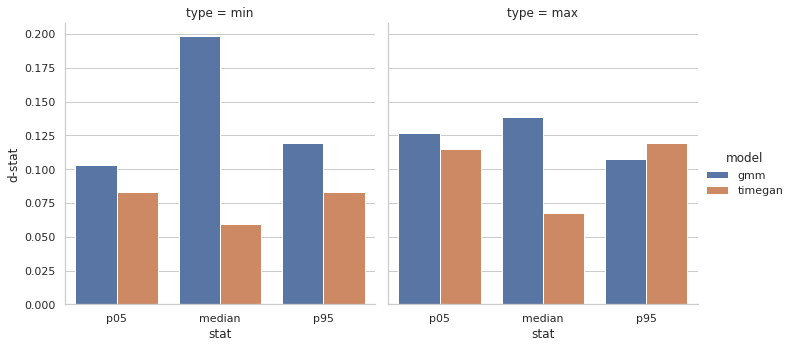

In [31]:
dstats_min_gmm = [perform_kstest(real_min.p05 ,gmm_min.p05), perform_kstest(real_min.med ,gmm_min.med), perform_kstest(real_min.p95 ,gmm_min.p95)]
dstats_min_timegan = [perform_kstest(real_min.p05 ,timegan_min.p05), perform_kstest(real_min.med ,timegan_min.med), perform_kstest(real_min.p95, timegan_min.p95)]

dstats_max_gmm = [perform_kstest(real_max.p05 ,gmm_max.p05), perform_kstest(real_max.med ,gmm_max.med), perform_kstest(real_max.p95 ,gmm_max.p95)]
dstats_max_timegan = [perform_kstest(real_max.p05 ,timegan_max.p05), perform_kstest(real_max.med ,timegan_max.med), perform_kstest(real_max.p95, timegan_max.p95)]


dstat_dict = {'d-stat' : dstats_min_gmm + dstats_min_timegan + dstats_max_gmm + dstats_max_timegan , 'stat': ['p05', 'median', 'p95']*4, 'model': ['gmm']*3 + ['timegan']*3 + ['gmm']*3 + ['timegan']*3, 'type': ['min']*6 + ['max']*6}
dstat_df = pd.DataFrame(dstat_dict)
sns.catplot(data=dstat_df,  y='d-stat', x='stat', hue='model', kind='bar', col='type')

## Normalised

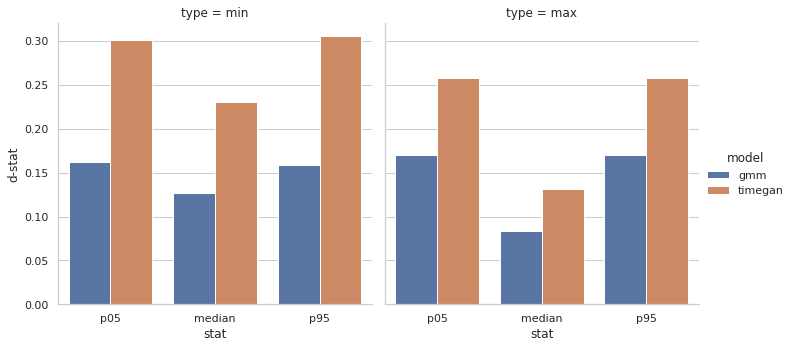

In [32]:
dstats_min_gmm = [perform_kstest(loadflow_min.p05 ,gmm_norm_min.p05), perform_kstest(loadflow_min.med ,gmm_norm_min.med), perform_kstest(loadflow_min.p95 ,gmm_norm_min.p95)]
dstats_min_timegan = [perform_kstest(loadflow_min.p05 ,timegan_norm_min.p05), perform_kstest(loadflow_min.med ,timegan_norm_min.med), perform_kstest(loadflow_min.p95, timegan_norm_min.p95)]

dstats_max_gmm = [perform_kstest(loadflow_max.p05 ,gmm_norm_max.p05), perform_kstest(loadflow_max.med ,gmm_norm_max.med), perform_kstest(loadflow_max.p95 ,gmm_norm_max.p95)]
dstats_max_timegan = [perform_kstest(loadflow_max.p05 ,timegan_norm_max.p05), perform_kstest(loadflow_max.med ,timegan_norm_max.med), perform_kstest(loadflow_max.p95, timegan_norm_max.p95)]


dstat_dict = {'d-stat' : dstats_min_gmm + dstats_min_timegan + dstats_max_gmm + dstats_max_timegan , 'stat': ['p05', 'median', 'p95']*4, 'model': ['gmm']*3 + ['timegan']*3 + ['gmm']*3 + ['timegan']*3, 'type': ['min']*6 + ['max']*6}
dstat_df = pd.DataFrame(dstat_dict)
sns.catplot(data=dstat_df,  y='d-stat', x='stat', hue='model', kind='bar', col='type')
